In [8]:
# This is a python script that generates the input data
# variable x resolution

import numpy as np
import math
import sys
import matplotlib.pyplot as plt


def write_bin(fname, data):
    # print('no saving allowed')
    data.astype(">f8").tofile(fname)


In [9]:


# Dimensions of grid
H = 1000.0
Lx = 32.0e3
Ly = 10

nx = 64*50#400
ny = 1
nz = 300#20

dx = Lx / nx
dy = Ly / ny
dz = H / nz
print('dx:',dx," dy:",dy," dz:",dz)
# Some constants
gravity = 9.81
sbeta = 8.0e-4
talpha = 0.4e-4
rho0 = 999.8
T0 = 1
S0 = 35

x = np.zeros([nx, ny])
x[0, :] = dx / 2

for i in np.arange(1, nx):
    x[i] = x[i - 1] + dx


z = -dz / 2 + np.arange(0, -H, -dz)


dx: 10.0  dy: 10.0  dz: 3.3333333333333335


no saving allowed
no saving allowed
no saving allowed
no saving allowed
no saving allowed


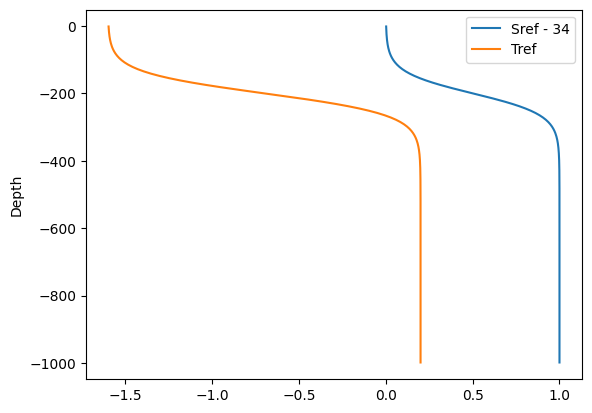

In [10]:

# Temperature profile
tcd = -200
Tmin = -1.6
Tmax = 0.2
Tc = (Tmax + Tmin) / 2
Trange = Tmax - Tmin
T2 = Tc - Trange / 2 * np.tanh(np.pi * (z - tcd) / 200)
Tconst = np.zeros([nz]) + 0.4

T = T2

Sc = 34.5
Srange = -1
S2 = Sc + Srange / 2 * np.tanh(np.pi * (z - tcd) / 200)
Sconst = np.zeros([nz]) + 35

S = S2

Rref = rho0 * (1 - talpha * (T - T0) + sbeta * (S - S0))

t = np.zeros([nz, ny, nx])
s = np.zeros([nz, ny, nx])

for k in np.arange(0, nz):
    t[k, :, :] = t[k, :, :] + T[k]
    s[k, :, :] = s[k, :, :] + S[k]

ubound = np.zeros([ny, nz])

write_bin("T.init", t)
write_bin("S.init", s)
write_bin("S.bound", S)
write_bin("T.bound", T)
write_bin("U.bound", ubound)


plt.plot(S - 34, z, label="Sref - 34")
plt.plot(T, z, label="Tref")
plt.ylabel('Depth')
plt.legend()
plt.savefig("initialTS")
plt.show()



no saving allowed
no saving allowed
no saving allowed


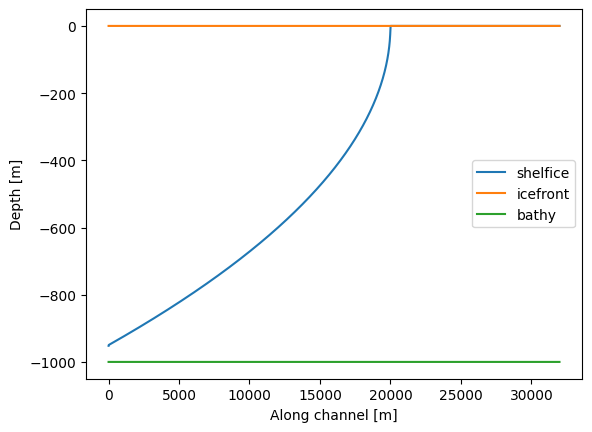

In [11]:
# Topographie

d = np.zeros([nx, ny]) - H
# d[0, :] = 0

# write_bin("topog.slope", d)

# Ice shelf
gldepth = -H + 50
icebase = -50
sgdd = 48
L = [0, 50, 20000]  #regions for slope changes
D = [-H + sgdd, gldepth, icebase] #dept at these locations

iceshelf = np.zeros([nx, ny])   #bottom of shelf
icefront = np.zeros([nx, ny])   #not sure
m = np.zeros([nx, ny])          #not sure what this is

# for j in np.arange(0, ny):
#     # print(j)
#     for i in np.arange(1, np.shape(D)[0]):
#         xi = np.where((x >= L[i - 1]) & (x < L[i]))[0]
#         #print(np.size(xi))
#         m[xi, j] = (D[i] - D[i - 1]) / (L[i] - L[i - 1])
#         iceshelf[xi, j] = np.linspace(D[i - 1], D[i], np.size(xi))
#         #print(np.linspace(D[i - 1], D[i], np.size(xi)))
#         icefront[xi, j] = np.linspace(D[i - 1], D[i], np.size(xi))
xi = np.where(x<= L[-1])
xi_p1 = np.where(x<= L[-1])
iceshelf[xi,0] = 0 + gldepth/np.sqrt(L[-1])*np.sqrt(np.abs(x[xi] - L[-1]))
# icefront[xi,0] = (iceshelf[0:-2,0] - iceshelf[1:-1,0])/dx

iceshelf[0, :] = D[0]
icefront[0, :] = D[0]

iceshelf[x > L[-1]] = 0        #if past the front, no ice
icefront[x > L[-1]] = 0        #if past the front, no ice
# iceshelf[m > dz / dx] = np.nanmin(iceshelf[m < dz / dx])
icefront[m < dz / dx] = 0      #if m is less than minimum slope, set to 0
icelength = np.zeros([nx, ny])
icelength[icefront < 0] = 1 / dy

a0 = -0.0573
c0 = 0.0832
b = -7.53e-4

if sgdd != 0:
    sgdu = np.zeros([ny, nz])
    sgdS = np.zeros([ny, nz])
    sgdT = np.zeros([ny, nz])
    sgd = 0.001
    sgdi = np.where((z < gldepth) & (z >= gldepth - sgdd))
    sgdu[:, sgdi] = sgd / dy / sgdd
    sgdS[:, sgdi] = 30
    sgdT[:, sgdi] = a0 * sgdS[:, sgdi] + c0 + b * -z[sgdi]
    write_bin("T.sgd", sgdT)
    write_bin("S.sgd", sgdS)
    write_bin("U.sgd", sgdu)


plt.plot(x, iceshelf[:, 0], label="shelfice")
# plt.plot(sgdu * 1000, z)
plt.plot(x, icefront[:, 0], label="icefront")
plt.plot(x, d[:, 0], label="bathy")
plt.ylabel('Depth [m]')
plt.xlabel('Along channel [m]')
plt.legend()
plt.savefig("geo")
plt.show()

# write_bin("icetopo.exp1", iceshelf)
# write_bin("icefrontdepth", icefront)
# write_bin("icefrontlength", icelength)



In [12]:
x[xi]

array([5.0000e+00, 1.5000e+01, 2.5000e+01, ..., 1.9975e+04, 1.9985e+04,
       1.9995e+04])

In [13]:
gldepth

-950.0

In [14]:
# Phi 0

pano = np.zeros([nx, ny])
for i in np.arange(0, nx):
    ki = np.where(z >= iceshelf[i])[0]

    if not ki.size > 0:
        pextra = 0
        panoex = 0
        ptop = 0
    else:
        k = np.nanmax(ki)
        ptop = np.sum(Rref[0:k] * gravity * dz)  # Ice pressure
        ptopano = ptop - rho0 * gravity * dz * (k + 1)  # Ice pressure anomaly
        pextra = abs(z[k] - iceshelf[i]) * gravity * rho0
        panoex = pextra - abs(z[k] - iceshelf[i]) * gravity * Rref[k]

    pano[i, :] = panoex + ptopano


# write_bin("phi0.exp1", pano)
